# Setup

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [10,6]

train_csv = pd.read_csv('train.csv')
valid_csv = pd.read_csv('dev.csv')
whole_csv = pd.concat([train_csv, valid_csv], axis=0, ignore_index=True)

# Preliminary Feature Models (not using Review Contents)
Let's try to establish a baseline model which doesn't rely heavily on the review data, since text data requires some fairly heavy data processing.

### Data Processing:
- User review count
- Restaurant review count
- Days since first user review
- Days since first restaurant review
- Review word count
- Review letter count
- Review capitalization count
- Review punctuation count
- Review rating (provided in base dataset)

To avoid leakage, we have to do the *historical* review counts.

In [2]:
def preliminary_feature(data):
    data['user_review_count'] = data.sort_values(['user_id','date']).groupby('user_id')['ex_id'].cumcount()
    data['user_average_rating'] = data.sort_values(['user_id', 'date']).groupby('user_id')['rating'].cumsum() \
                                  / (data['user_review_count'] + 1)
    data['restaurant_review_count'] = data.sort_values(['prod_id', 'date']).groupby('prod_id')['ex_id'].cumcount()
    data['restaurant_average_rating'] = data.sort_values(['prod_id', 'date']).groupby('prod_id')['rating'].cumsum() \
                                        / (data['restaurant_review_count'] + 1)
    data['wordcount'] = data['review'].str.count(" ")
    first_user_review = data.groupby('user_id')['date'].min()
    data['days_since_first_user'] = (pd.to_datetime(data.set_index('user_id')['date']) \
                                     - pd.to_datetime(first_user_review))\
                                    .dt.days.reset_index(drop=True)
    first_restaurant_review = data.groupby('prod_id')['date'].min()
    data['days_since_first_restaurant'] = (pd.to_datetime(data.set_index('prod_id')['date']) \
                                           - pd.to_datetime(first_restaurant_review)) \
                                          .dt.days.reset_index(drop=True)
    data['punctuation_count'] = data['review'].str.count('[,;:!.]')
    data['capitalization_count'] = data['review'].str.count('[A-Z]+')
    data['letter_count'] = data['review'].str.len()
    
    return data

In [3]:
whole = preliminary_feature(whole_csv)

In [4]:
print(whole.columns)

Index(['ex_id', 'user_id', 'prod_id', 'rating', 'label', 'date', 'review',
       'user_review_count', 'user_average_rating', 'restaurant_review_count',
       'restaurant_average_rating', 'wordcount', 'days_since_first_user',
       'days_since_first_restaurant', 'punctuation_count',
       'capitalization_count', 'letter_count'],
      dtype='object')


In [5]:
train = whole[:250874]
print("Original:", len(train_csv), "FE:", len(train))

Original: 250874 FE: 250874


In [6]:
valid = whole[250874:].reset_index()
print("Original:", len(valid_csv), "FE:", len(valid))

Original: 35918 FE: 35918


In [25]:
# Add train_spammer flag
train['spammed'] = train.sort_values(['user_id','date']).groupby('user_id')['label'].cumsum() > 1
train_spammers = train[train.spammed==True][['user_id', 'spammed']].drop_duplicates()
valid = valid.merge(train_spammers, how='left', on='user_id')
valid['spammed'] = valid['spammed'].fillna(False)

C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Models Trained: 

- Logistic Regression
- XGBoost
- XGBoost with adjustment for class imbalance

In [7]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [26]:
train_features = ['rating', 'user_review_count', 'user_average_rating', 'restaurant_review_count', 
                  'restaurant_average_rating',
                  'punctuation_count', 'wordcount', 'capitalization_count', 'letter_count',
                  'days_since_first_user', 'days_since_first_restaurant', 'spammed']

In [27]:
X_train = train[train_features]
y_train = train['label']

lr = LogisticRegression(max_iter = 800)
lr.fit(X_train, y_train)

tree = XGBClassifier(random_state=42)
tree.fit(X_train, y_train)

tree_balanced = XGBClassifier(scale_pos_weight= (len(y_train)-y_train.sum()) / y_train.sum(), random_state=42)
tree_balanced.fit(X_train, y_train)

C:\Users\sujeong\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=8.716642782447035, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [28]:
train['pred_lr'] = lr.predict_proba(train[train_features])[:,1]
train['pred_tree'] = tree.predict_proba(train[train_features])[:,1]
train['pred_tree_balanced'] = tree_balanced.predict_proba(train[train_features])[:,1]

C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [29]:
X_valid = valid[train_features]
y_valid = valid['label']

In [30]:
valid['pred_lr'] = lr.predict_proba(valid[train_features])[:,1]
valid['pred_tree'] = tree.predict_proba(valid[train_features])[:,1]
valid['pred_tree_balanced'] = tree_balanced.predict_proba(valid[train_features])[:,1]

In [31]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(pred, y, label, title=None):
    precision, recall, _ = precision_recall_curve(y, pred)
    aps = average_precision_score(y_true=y, y_score=pred)
    
    plt.step(recall, precision, alpha=0.2,
             where='post',
             label='{}: Average Precision = {:0.3f}'.format(label, aps))
    plt.fill_between(recall, precision, step='post', alpha=0.2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if title is None:
        title = 'Precision-Recall Curve'
    plt.title(title)
    plt.legend(loc="lower right")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

### Train set performance

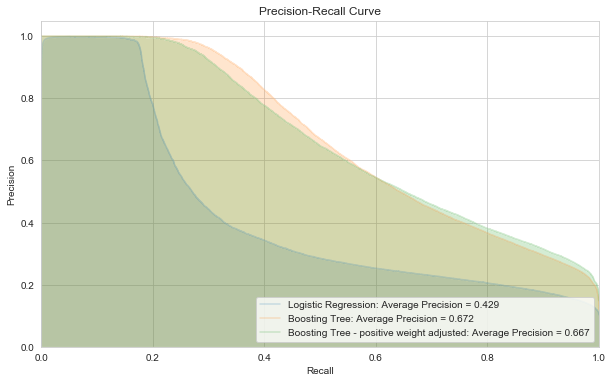

In [32]:
plot_pr(train['pred_lr'], train['label'], label='Logistic Regression')
plot_pr(train['pred_tree'], train['label'], label='Boosting Tree')
plot_pr(train['pred_tree_balanced'], train['label'], label='Boosting Tree - positive weight adjusted')

### Validation set performance

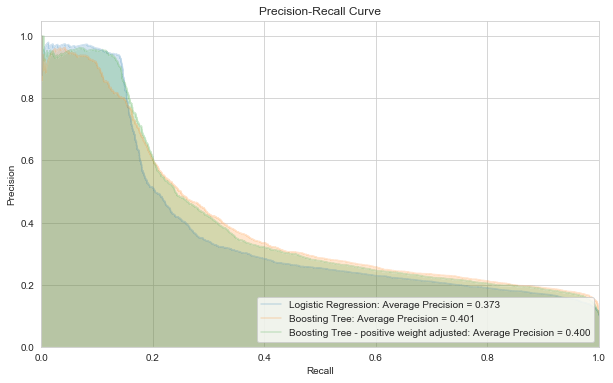

In [33]:
plot_pr(valid['pred_lr'], valid['label'], label='Logistic Regression')
plot_pr(valid['pred_tree'], valid['label'], label='Boosting Tree')
plot_pr(valid['pred_tree_balanced'], valid['label'], label='Boosting Tree - positive weight adjusted')

# Kitchen Sink Model

### Model: 
- XGBoost without adjustment for class imblance
- XGBoost with adjustment for class imblance

### Features:
12 + 32 = 44 features in total
- rating
- user_review_count
- user_average_rating
- restaurant_review_count
- restaurant_average_rating
- punctuation_count
- wordcount
- capitalization_count
- letter_count
- days_since_first_user
- days_since_first_restaurant
- pred_nb
- Word2Vec (vector size=32)

#### ↓ Prediction from MultinomialNB - TFIDF

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [35]:
cv = TfidfVectorizer(binary=False, ngram_range=(1,1), max_df=.5, min_df=.001)
text_data_train = cv.fit_transform(train['review'].tolist())
text_data_valid = cv.transform(valid['review'].tolist())

print(text_data_train.shape)
print(text_data_valid.shape)

(250874, 4701)
(35918, 4701)


C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


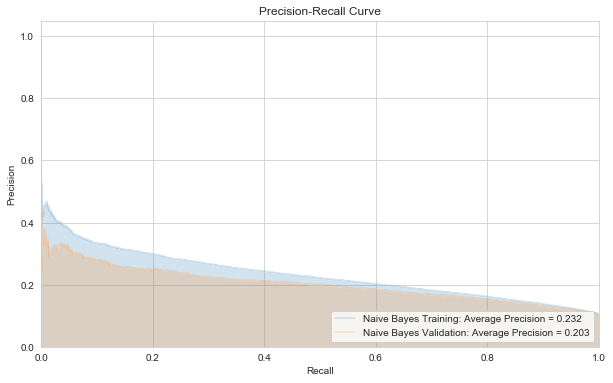

In [36]:
nb = MultinomialNB()
nb.fit(text_data_train, train['label'])

train['pred_nb'] = nb.predict_proba(text_data_train)[:,1]
valid['pred_nb'] = nb.predict_proba(text_data_valid)[:,1]

plot_pr(train['pred_nb'], train['label'], label='Naive Bayes Training')
plot_pr(valid['pred_nb'], valid['label'], label='Naive Bayes Validation')

#### ↓ Word2Vec using Gensim

In [19]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [20]:
documents_train = [TaggedDocument(doc, [i]) for i, doc in enumerate(train['review'].str.split(" "))]

In [21]:
d2v = Doc2Vec(documents_train, vector_size=32, window=2, min_count=100)

In [22]:
d2v_df_train = train['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_train.columns = ['d2v_' + str(x) for x in d2v_df_train.columns]

In [23]:
d2v_df_valid = valid['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_valid.columns = ['d2v_' + str(x) for x in d2v_df_valid.columns]

C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


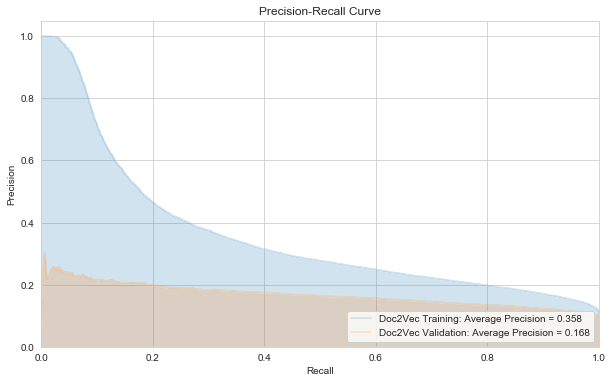

In [37]:
tree_d2v = XGBClassifier(random_state=42)
tree_d2v.fit(d2v_df_train, train['label'])

train['pred_d2v'] = tree_d2v.predict_proba(d2v_df_train)[:,1]
valid['pred_d2v'] = tree_d2v.predict_proba(d2v_df_valid)[:,1]

plot_pr(train['pred_d2v'], train['label'], label='Doc2Vec Training')
plot_pr(valid['pred_d2v'], valid['label'], label='Doc2Vec Validation')

#### ↓ Putting everything together

In [39]:
everything_train = pd.concat([train, d2v_df_train], axis=1)
everything_valid = pd.concat([valid, d2v_df_valid], axis=1)
everything_features = train_features + ['pred_nb'] + d2v_df_train.columns.tolist()
everything_features

['rating',
 'user_review_count',
 'user_average_rating',
 'restaurant_review_count',
 'restaurant_average_rating',
 'punctuation_count',
 'wordcount',
 'capitalization_count',
 'letter_count',
 'days_since_first_user',
 'days_since_first_restaurant',
 'spammed',
 'pred_nb',
 'd2v_0',
 'd2v_1',
 'd2v_2',
 'd2v_3',
 'd2v_4',
 'd2v_5',
 'd2v_6',
 'd2v_7',
 'd2v_8',
 'd2v_9',
 'd2v_10',
 'd2v_11',
 'd2v_12',
 'd2v_13',
 'd2v_14',
 'd2v_15',
 'd2v_16',
 'd2v_17',
 'd2v_18',
 'd2v_19',
 'd2v_20',
 'd2v_21',
 'd2v_22',
 'd2v_23',
 'd2v_24',
 'd2v_25',
 'd2v_26',
 'd2v_27',
 'd2v_28',
 'd2v_29',
 'd2v_30',
 'd2v_31']

In [44]:
y_train = train['label']
pos_ratio = (len(y_train)-y_train.sum()) / y_train.sum()

everything_model = XGBClassifier(scale_pos_weight=pos_ratio, max_depth=4, reg_alpha=5, reg_lambda=30, random_state=42)
everything_model.fit(everything_train[everything_features], y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=5,
              reg_lambda=30, scale_pos_weight=8.716642782447035, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

C:\Users\sujeong\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


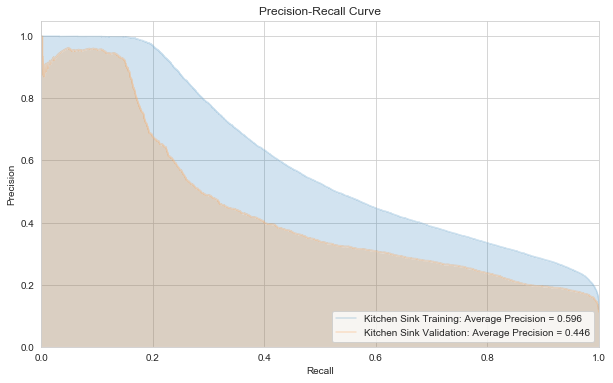

In [45]:
train['pred_everything'] = everything_model.predict_proba(everything_train[everything_features])[:,1]
valid['pred_everything'] = everything_model.predict_proba(everything_valid[everything_features])[:,1]

plot_pr(train['pred_everything'], train['label'], label='Kitchen Sink Training')
plot_pr(valid['pred_everything'], valid['label'], label='Kitchen Sink Validation')

### Test Set

In [46]:
# load test set 
test_csv = pd.read_csv('test_no_label.csv').sort_values('ex_id')
whole_csv = pd.concat([train_csv, test_csv], axis=0, ignore_index=True)

In [47]:
# Apply preliminary_feature
whole = preliminary_feature(whole_csv)
test = whole[250874:].reset_index()

In [48]:
# MNB prediction on test
text_data_test = cv.transform(test['review'].tolist())
test['pred_nb'] = nb.predict_proba(text_data_test)[:,1]

In [49]:
# Word2Vec using Gensim
d2v_df_test = test['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_test.columns = ['d2v_' + str(x) for x in d2v_df_test.columns]

In [50]:
everything_test = pd.concat([test, d2v_df_test], axis=1)
everything_test = everything_test.merge(train_spammers, how='left', on='user_id')
everything_test['spammed'] = everything_test['spammed'].fillna(False)

In [51]:
predictions = everything_model.predict(everything_test[everything_features], output_margin=True)

In [ ]:
pd.DataFrame(predictions).to_csv('predictions.csv', index=False, header=False)